# Flow lines for reversibility experiments

In this notebook I take some of the tracking datasets from the reversibility experiments of Nov-2017 and I look at the tangential velocity as a function of time. This is to see if some of them have persistent velocities. 

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy as cp
import scipy.optimize as spo
import scipy.signal as spsg

%matplotlib inline

In [2]:
traj_name_1 = '//MAGNETIC/Antonio/LargeData/2017-11-21-Data/BeamReflection_2017_11_21_12_05_28.dat'

traj_1 = pd.read_csv(traj_name_1, sep='\t',header=0)

In [3]:
no_of_col = traj_1.shape[1]
no_of_part = round((no_of_col-1)/2)

new_col_names = ['t']+['%s_%u'%(j,i) for i in range(no_of_part) for j in ("x","y")]

traj_1.columns = new_col_names

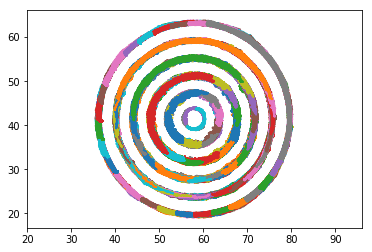

In [4]:
for i in np.arange(0,no_of_part):
    plt.plot(traj_1['x_%u'%i], traj_1['y_%u'%i])
plt.axis('equal');

I want to turn this array into a sparse representation. This is mainly for consistency, but I also don't particularly like the indexing method with the string labels. I think it's cumbersome. 

Also, new fields are easily added to a sparse representation, whereas the dense representation needs new arrays for each new quantity. 

It seems that the most natural representation for trayectories is multi-index.

In [5]:
no_of_frame = traj_1.shape[0]

#part = list(range(0,no_of_part))
#frame = list(range(0,pd.MultiIndex.from_product))

For the moment, I'll try simply to get it from the current representation

Get approximate center

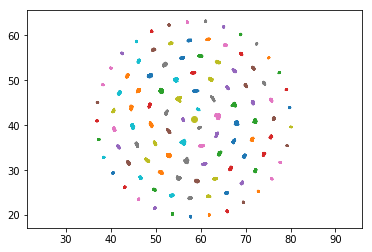

In [6]:
t_max = 1000

plt.plot(traj_1.iloc[0:t_max,1::2],traj_1.iloc[0:t_max,2::2])
plt.plot(58.5,41.5,'o')
plt.axis('equal');

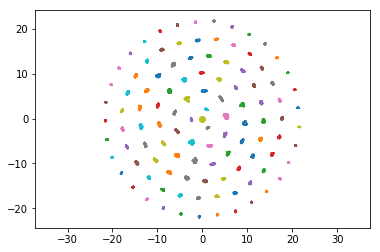

In [7]:
x_c = 58.5
y_c = 41.5

traj_1_approx_center = cp.deepcopy(traj_1)
traj_1_approx_center.iloc[:,1::2] = traj_1_approx_center.iloc[:,1::2] - x_c
traj_1_approx_center.iloc[:,2::2] = traj_1_approx_center.iloc[:,2::2] - y_c

plt.plot(traj_1_approx_center.iloc[0:t_max,1::2],traj_1_approx_center.iloc[0:t_max,2::2])
plt.plot(0,0,'o')
plt.axis('equal');

Now we need to calculate an approximate polar coordinates

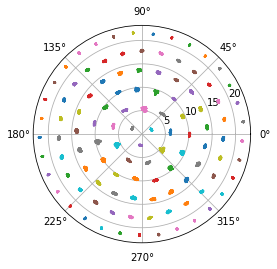

In [8]:
traj_1_approx_polar = cp.deepcopy(traj_1_approx_center)

new_col_names = ['t']+['%s_%u'%(j,i) for i in range(no_of_part) for j in ("p","p")]

traj_1_approx_center.columns = new_col_names
traj_1_approx_polar.columns = new_col_names

traj_1_approx_polar.iloc[:,1::2] = np.sqrt(traj_1_approx_center.iloc[:,1::2]**2 + traj_1_approx_center.iloc[:,2::2]**2)
traj_1_approx_polar.iloc[:,2::2] = np.arctan2(traj_1_approx_center.iloc[:,1::2],traj_1_approx_center.iloc[:,2::2])

new_col_names = ['t']+['%s_%u'%(j,i) for i in range(no_of_part) for j in ("x","y")]
traj_1_approx_center.columns = new_col_names

new_col_names = ['t']+['%s_%u'%(j,i) for i in range(no_of_part) for j in ("r","phi")]
traj_1_approx_polar.columns = new_col_names

plt.polar(traj_1_approx_polar.iloc[0:t_max,2::2],traj_1_approx_polar.iloc[0:t_max,1::2]);

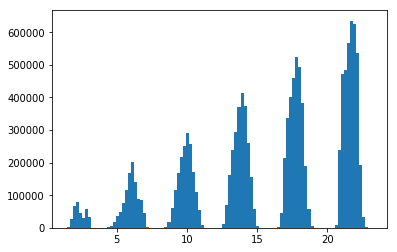

In [14]:
plt.hist(traj_1_approx_polar.iloc[:,1::2].values.flatten(),bins=100);

In [18]:
layer_out_indx = np.where(traj_1_approx_polar.iloc[0,1::2]>20)[0]

(-25.257950000000005, 24.130950000000009, -24.7818, 24.581800000000001)

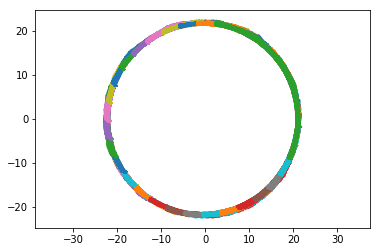

In [33]:
plt.plot(traj_1_approx_center.iloc[:,(layer_out_indx)*2+1],traj_1_approx_center.iloc[:,(layer_out_indx)*2+2]);
plt.axis('equal')

In [45]:
method_2 = "leastsq"

x = traj_1_approx_center.iloc[:,(layer_out_indx)*2+1].values.flatten()
y = traj_1_approx_center.iloc[:,(layer_out_indx)*2+2].values.flatten()

def calc_R(xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(*c)
    return Ri - Ri.mean()

center_estimate = 0, 0
center_2, ier = spo.leastsq(f_2, center_estimate)

xc_2, yc_2 = center_2
Ri_2       = calc_R(*center_2)
R_2        = Ri_2.mean()
residu_2   = sum((Ri_2 - R_2)**2)

In [46]:
xc_2,yc_2

(-0.54442624850930488, -0.065108860072389016)

In [52]:
traj_1_center = cp.deepcopy(traj_1_approx_center)

traj_1_center.iloc[:,1::2] = traj_1_center.iloc[:,1::2] - xc_2
traj_1_center.iloc[:,2::2] = traj_1_center.iloc[:,2::2] - yc_2

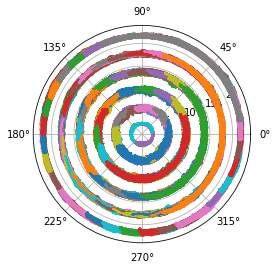

In [53]:
traj_1_polar = cp.deepcopy(traj_1_center)

new_col_names = ['t']+['%s_%u'%(j,i) for i in range(no_of_part) for j in ("p","p")]

traj_1_center.columns = new_col_names
traj_1_polar.columns = new_col_names

traj_1_polar.iloc[:,1::2] = np.sqrt(traj_1_center.iloc[:,1::2]**2 + traj_1_center.iloc[:,2::2]**2)
traj_1_polar.iloc[:,2::2] = np.arctan2(traj_1_center.iloc[:,1::2],traj_1_center.iloc[:,2::2])

new_col_names = ['t']+['%s_%u'%(j,i) for i in range(no_of_part) for j in ("x","y")]
traj_1_center.columns = new_col_names

new_col_names = ['t']+['%s_%u'%(j,i) for i in range(no_of_part) for j in ("r","phi")]
traj_1_polar.columns = new_col_names

plt.polar(traj_1_polar.iloc[:,2::2],traj_1_polar.iloc[:,1::2]);

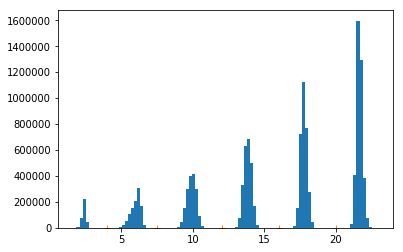

In [73]:
plt.hist(traj_1_polar.iloc[:,1::2].values.flatten(),bins=100);
plt.plot([4,7.5,12,16,20],[0,0,0,0,0],'+')
layer_lim = [0,4,7.5,12,16,20,np.inf];

In [85]:
layers = pd.cut(traj_1_polar.iloc[:,1::2].mean(),layer_lim,labels=[0,1,2,3,4,5])

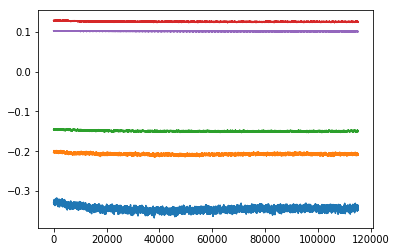

In [179]:
layer1_indx = np.where(layers==1)[0]
layer2_indx = np.where(layers==2)[0]
layer3_indx = np.where(layers==3)[0]
layer4_indx = np.where(layers==4)[0]
layer5_indx = np.where(layers==5)[0]

plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar.iloc[:,(layer1_indx)*2+2],axis=0)),axis=1))
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar.iloc[:,(layer2_indx)*2+2],axis=0)),axis=1))
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar.iloc[:,(layer3_indx)*2+2],axis=0)),axis=1))
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar.iloc[:,(layer4_indx)*2+2],axis=0)),axis=1))
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar.iloc[:,(layer5_indx)*2+2],axis=0)),axis=1))
#plt.xlim([80000,90000])

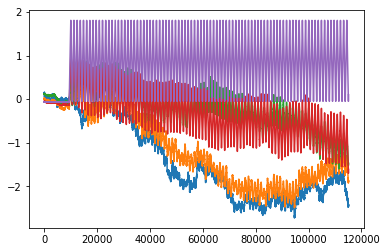

In [176]:
layer1_indx = np.where(layers==1)[0]
layer2_indx = np.where(layers==2)[0]
layer3_indx = np.where(layers==3)[0]
layer4_indx = np.where(layers==4)[0]
layer5_indx = np.where(layers==5)[0]

plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[:,(layer1_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[:,(layer2_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[:,(layer3_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[:,(layer4_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[:,(layer5_indx)*2+2],axis=0),axis=1));

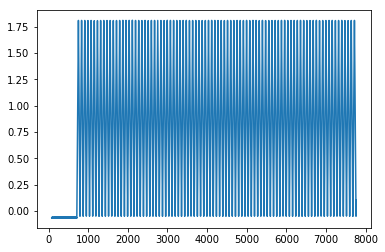

In [183]:
drive = np.mean(np.unwrap(traj_1_polar.iloc[:,(layer5_indx)*2+2],axis=0),axis=1)
t = traj_1_polar.iloc[:,0]
plt.plot(t,drive);

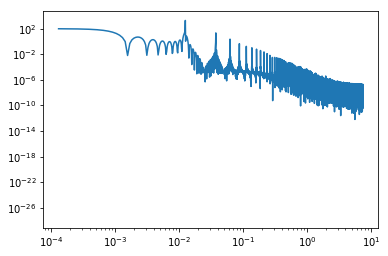

In [228]:
framerate = 1/np.mean(t.diff())
f, PSD = spsg.periodogram(drive,fs=1/np.mean(t.diff()))
plt.loglog(f,PSD)

In [237]:
period = np.int(np.ceil(framerate/f[np.argmax(PSD)]))

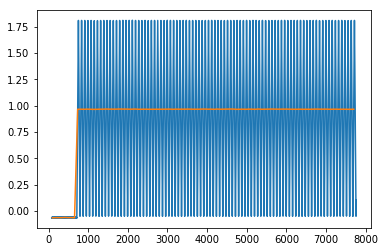

In [255]:
phase = 200
static = 0
drive_strobo = drive[static+phase::period]
t_strobo = t[static+phase::period]
plt.plot(t,drive);
plt.plot(t_strobo,drive_strobo);


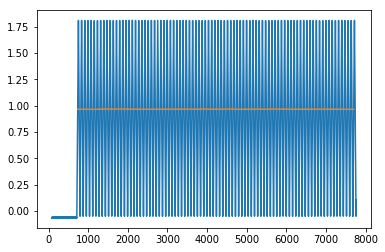

In [260]:
strobo_series = np.arange(phase,np.size(t),period)

static_frames = 8
driven_strobo_series = strobo_series[static_frames::]

plt.plot(t,drive);
plt.plot(t[driven_strobo_series],drive[driven_strobo_series]);

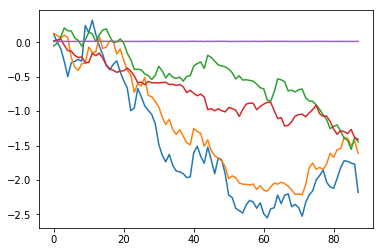

In [261]:
layer1_indx = np.where(layers==1)[0]
layer2_indx = np.where(layers==2)[0]
layer3_indx = np.where(layers==3)[0]
layer4_indx = np.where(layers==4)[0]
layer5_indx = np.where(layers==5)[0]

plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[driven_strobo_series,(layer1_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[driven_strobo_series,(layer2_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[driven_strobo_series,(layer3_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[driven_strobo_series,(layer4_indx)*2+2],axis=0),axis=1));
plt.plot(np.mean(np.unwrap(traj_1_polar.iloc[driven_strobo_series,(layer5_indx)*2+2],axis=0),axis=1));

In [262]:
traj_1_polar_strobo = traj_1_polar.iloc[driven_strobo_series,:]

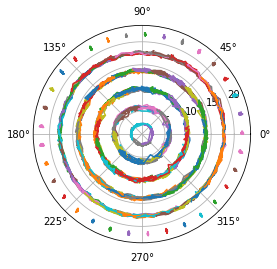

In [263]:
plt.polar(traj_1_polar_strobo.iloc[:,2::2],traj_1_polar_strobo.iloc[:,1::2]);

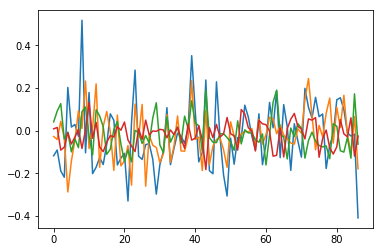

In [277]:
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer1_indx)*2+2],axis=0),axis=0),axis=1));
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer2_indx)*2+2],axis=0),axis=0),axis=1));
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer3_indx)*2+2],axis=0),axis=0),axis=1));
plt.plot(np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer4_indx)*2+2],axis=0),axis=0),axis=1));

This looks noisy. However, there seems to be a clear drift, which would indicate a net angular velocity. It's strange that there doesn't seem to be any persistent velocity. 

What does the correlation look like?

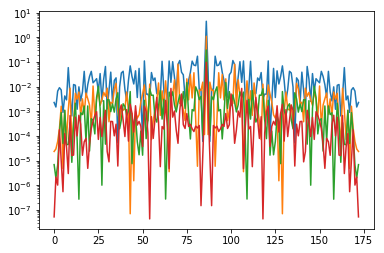

In [283]:
vel_layer_1 = np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer1_indx)*2+2],axis=0),axis=0),axis=1)
vel_layer_2 = np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer2_indx)*2+2],axis=0),axis=0),axis=1)
vel_layer_3 = np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer3_indx)*2+2],axis=0),axis=0),axis=1)
vel_layer_4 = np.mean(np.diff(np.unwrap(traj_1_polar_strobo.iloc[:,(layer4_indx)*2+2],axis=0),axis=0),axis=1)

corr_layer_1 = spsg.correlate(vel_layer_1,vel_layer_1)
corr_layer_2 = spsg.correlate(vel_layer_2,vel_layer_2)
corr_layer_3 = spsg.correlate(vel_layer_3,vel_layer_3)
corr_layer_4 = spsg.correlate(vel_layer_4,vel_layer_4)

plt.semilogy(corr_layer_1**2)
plt.semilogy(corr_layer_2**2)
plt.semilogy(corr_layer_3**2)
plt.semilogy(corr_layer_4**2)

It's not convincingly correlated. It looks very similar to a dirac delta, which we would expect for brownian motion. 